In [1]:
print('https://www.whatismybrowser.com/detect/what-is-my-user-agent/')

https://www.whatismybrowser.com/detect/what-is-my-user-agent/


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os, sys
import shutil
import cv2

from tqdm.notebook import tqdm 
from google.colab import drive
from datetime import datetime
from pytz import timezone
from glob import glob 

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/collage')

# 구글 드라이브 내에 필요 패키지 설치를 위한 경로 설정 
try:
    os.mkdir('./packages')
except:
    print('-')
link_name = '/packages'
target = '/content/drive/My Drive/Colab Notebooks/collage/packages'
try:
  os.symlink(target, link_name)
except:
  os.chdir(target)
  os.remove(link_name)
  os.symlink(target, link_name)
sys.path.insert(0, link_name)

# 스크래핑에 필요한 헤더정보 정의
# 실행을 위해서는 각 환경에 맞는 유저에이전트 정보 필요 
headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-


In [3]:
## 필요 패키지 설치
# !pip --version
# !pip install --target=$link_name --upgrade pip
# !pip install --target=$link_name --use-deprecated=legacy-resolver git+https://github.com/kakaobrain/pororo.git
# !pip install --target=$link_name konlpy
# !pip install --target=$link_name python-mecab-ko
# !pip install --target=$link_name kollocate
# !pip install --target=$link_name koparadigm1
# !pip install --target=$link_name g2pk
# !pip install --target=$link_name selenium
# !pip install --target=$link_name webdriver_manager
# !pip install --target=$link_name cairosvg

!pip --target=$link_name install Django
## 셀레니움 스크래핑에 필요한 크롬 드라이버 설치 
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [3,369 kB]
Hit:14 http://ppa.launchpad.net

In [4]:
# 설치한 자연어 처리모듈 뽀로로 및 직접정의한 py파일들 로드 / py파일에서 정의한 모든 주석은 각 py파일에 포함함
from pororo import Pororo

os.chdir('/content/drive/MyDrive/Colab Notebooks/collage')
import cairosvg 
import arrange
import scrap
import seg

# 자연어 처리 객체를 미리 생성
summ = Pororo(task="summarization", model="abstractive", lang="ko")
se = Pororo(task="sentence_embedding")
ner = Pororo(task="ner", lang="ko")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [5]:
# 산출물을 담을 딕셔너리 생성
def return_trend_dict():
  '''
  산출물을 담을 딕셔너리 생성 앞으로 return_dict라 칭할예정
  '''
  return {'keyword': None, 'namuKeyword': None, 'namuKeyword_kind': None, 'articles': None, 'links':None, 'title_picked':None, 'article_summary':None, 'img_name':None, 'img':None, 'img_coor':None}

In [6]:
from google.colab import output
output.enable_custom_widget_manager()

In [7]:
# 시간 구분을 위함 
now = datetime.now(timezone('Asia/Seoul'))
datetime_text = str(now.strftime('%Y-%m-%d %H:%M'))

keyword_dicts = []
keyword_now = scrap.scrapSignalKeyword()

print(f'{datetime_text} : {keyword_now}')
for idx, keyword in tqdm(enumerate(keyword_now)):
  dict_ = return_trend_dict()
  articles, links = scrap.scrapNaverNewsKeyword(keyword, article_num=8, headers=headers, sort='1', length=350)
  # 원검색어
  dict_['keyword'] = keyword
  # 검색어에 대응하는 (제목, 내용)의 리스트
  dict_['articles'] = articles
  # 앞으로 이미지 파일을 저장할 파일 이름
  dict_['img_name'] = str(idx) + '.png'
  # 기사들에 대응하는 링크들
  dict_['links'] = links
  keyword_dicts.append(dict_)

2022-08-24 10:59 : ['요양병원 면회제한 유지', '우영우 박은빈', '선우은숙', '환혼', '아담 24라운드 MVP', '이재명 당원투표 박용진', '산이 결혼', '문재인', '미남당', '스맨파']


0it [00:00, ?it/s]

In [8]:
# 한자어들 대체
def keyword_replace(txt):
  '''
  txt : str / 대체될 텍스트
  '''
  per_dict = { '尹':'윤석열', '文':'문재인', '與': '국민의힘', '野': '더불어민주당', }
  for word, replacement in per_dict.items():
    txt = txt.replace(word, replacement)
  return txt

In [9]:
def find_namukey(keyword, check_all=False, ):
  '''
  텍스트에서 ner이후 나무위키에서 사진을 가지고올 키워드들을 찾아내기 위한 함수
  인물을 우선적으로 추출

  keyword : 사진을 찾을 검색어를 찾으
  '''
  # 단어를 대체
  ner_result = ner(keyword_replace(keyword))
  ner_person_list = [re[0] for re in ner_result if re[1]=='PERSON']
  ner_or_list = [re[0] for re in ner_result if re[1]=='ORGANIZATION']
  ner_arti_list = [re[0] for re in ner_result if re[1]=='ARTIFACT']
  ner_city_list = [re[0] for re in ner_result if re[1]=='CITY']
  # 인물 키워드 뿐만 아니라 기관이나 도시같은 키워드도 반환
  if check_all:
    if len(ner_person_list) > 0:
      for p in ner_person_list:
        if keyword == p:
          return p, 'person'
      return ner_person_list[0], 'person'

    elif len(ner_or_list) > 0:
      for o in ner_or_list:
        if keyword == o:
          return o, 'organization'
      return ner_or_list[0], 'organization'

    elif len(ner_arti_list) > 0:
      for a in ner_arti_list:
        if keyword == a:
          return a, 'artifact'
      return ner_arti_list[0], 'artifact'

    elif len(ner_city_list) > 0:
      for c in ner_city_list:
        if keyword == c:
          return c, 'city'
      return ner_city_list[0], 'city'
    else :
      return keyword, '-'
  else:
    if len(ner_person_list) > 0:
      for p in ner_person_list:
        if keyword == p:
          return p, 'person'
      return ner_person_list[0], 'person'
    else :
      return keyword, '-'

In [10]:
# 각 검색어마다 나무위키에 검색할 키워드와 키워드의 종류를 할당
for dict_ in tqdm(keyword_dicts):
  dict_['namuKeyword'], dict_['namuKeyword_kind'] = find_namukey(dict_['keyword'])
  # dict_['namuKeyword'], dict_['namuKeyword_kind'] = '-', '-'

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
print([k['namuKeyword'] for k in keyword_dicts])

['요양병원 면회제한 유지', '우영우', '선우은숙', '환혼', '아담', '이재명', '산이', '문재인', '미남당', '스맨파']


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def find_impor_title_idx(dict_):
  '''
  리턴 딕셔너리를 받아 해당 제목들의 cosine similarity를 구하여 스코어가 가장 높은 았던 제목의 인덱스를 반환하는 함수
  스코어가 가장 높은 제목이 현재의 이슈에 대한 내용을 담을 것이라는 가정하에 여러 기사들 사이에서 공통적인 내용을 의미하는 기사를 찾기 위함 

  dict_ : return_dict  
  '''

  titles = [keyword_replace(article[0].strip()) for article in dict_['articles']]
  titles_embedding = [se(t).reshape(1,-1) for t in titles]

  sims = []
  for i in range(len(titles_embedding)):
    cands = titles_embedding.copy()
    query = cands.pop(i)
    temp_num = 0
    for c in cands:
      temp_num += cosine_similarity(query, c)[0][0]
    sims.append(temp_num)
  max_ = max(sims)
  max_idx = sims.index(max_)

  return max_idx

In [13]:
def namukeyword_replace(txt):
  '''
  txt : str / 대체될 텍스트
  '''
  per_dict = { '검찰':'검찰청', '교직원공제회': '한국교직원공제회', '제주' : '제주특별자치도',  '경찰' : '대한민국 경찰청'}
  for word, replacement in per_dict.items():
    txt = txt.replace(word, replacement)
  return txt

In [14]:
for dict_ in tqdm(keyword_dicts):
  max_idx = find_impor_title_idx(dict_)
  dict_['title_picked'] = max_idx
  if dict_['namuKeyword_kind']=='-':
    # 적절한 검색키워드를 찾지 못한 경우 cosine_similarity가 가장 높았던 
    target_title = dict_['articles'][max_idx][0]
    dict_['namuKeyword'], dict_['namuKeyword_kind'] = find_namukey(target_title, check_all=True)
    dict_['namuKeyword'] = namukeyword_replace(dict_['namuKeyword'])


  dict_['article_summary'] = summ(dict_['articles'][max_idx][1],
                                  beam=5, 
                                  len_penalty=3,
                                  no_repeat_ngram_size=3,
                                  top_k=50,
                                  top_p=0.7,
                                  temperature=1.5
                                  )
  if dict_['namuKeyword_kind']=='-':
    target_content = dict_['article_summary']
    dict_['namuKeyword'], dict_['namuKeyword_kind'] = find_namukey(target_content, check_all=True)
    dict_['namuKeyword'] = namukeyword_replace(dict_['namuKeyword'])

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
print([k['namuKeyword'] for k in keyword_dicts])

['한덕수', '우영우', '선우은숙', '이재욱', '아담', '이재명', '산이', '문재인', '강미나', '스맨파']


In [16]:
try:
    os.mkdir('./result')
except:
    print('-')
os.chdir('/content/drive/MyDrive/Colab Notebooks/collage/result')
try:
    os.mkdir('./'+datetime_text)
except:
    pass
try:
    os.mkdir(f'./{datetime_text}/img')
    os.mkdir(f'./{datetime_text}/txt')
except:
    pass
# 각 검색어에 대응하는 나무위키검색키워드에 따라서 나무위키에서 이미지 크롤링 및 미리 스크래핑했던 기사들 파일로 저장
for i,dict_ in enumerate(keyword_dicts):
    # print(f"{dict_['keyword']} -> {(dict_['namuKeyword'])}")
    try:
        os.mkdir(f"./{datetime_text}/txt/{dict_['keyword']}")
    except:
        pass
    txt_path = f"./{datetime_text}/txt/{dict_['keyword']}"
    scrap.saveArticles(dict_['articles'], txt_path)
    img_path = f'./{datetime_text}/img/{i}.png'
    scrap.scrapNamuImg(dict_['namuKeyword'],img_path, headers=headers, namuKeyword_kind=dict_['namuKeyword_kind'])

-


In [17]:
try:
    os.mkdir('./'+datetime_text+'/segmentation')
except:
    print('-')
# 기학습한 모델 로드
model_present_path = '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/model_weight/DLv3+sgd0.01+unfreeze/sgd0.01.h5'
model_present = tf.keras.models.load_model(model_present_path)

In [18]:
face_detector = arrange.make_classifier('/content/drive/MyDrive/Colab Notebooks/collage/haarcascade_frontalface_alt.xml')

In [19]:
# 모델로 키워드가 사람인 경우에는 세그멘테이션 진행 이후 얼굴을 근처로 크롭
# 아닌 경우 (단체의 로고 따위) return_dict에만 저장
for dict_ in tqdm(keyword_dicts):
  load_path = f'./{datetime_text}/img/{dict_["img_name"]}'
  save_path = f'./{datetime_text}/segmentation/{load_path.split("/")[-1]}'
  if dict_['namuKeyword_kind'] == 'person':
    try:
      temp_img = seg.segSave(model_present, load_path, save_path=None)
      temp_img = arrange.crop_blank(temp_img)
      temp_img = arrange.crop_near_face(temp_img, face_detector)
      dict_['img'] = temp_img
      cv2.imwrite(save_path, temp_img)

    except:
      pass
  else:
    try:
      temp_img = cv2.imread(load_path, cv2.IMREAD_UNCHANGED)
      dict_['img'] = temp_img
    except:
      pass

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
# 이미지들에 흰테두리를 적용하고 배치좌표를 계산

img_list = [dict_['img'] for dict_ in keyword_dicts if dict_['img'] is not None]
img_names = [dict_['img_name'] for dict_ in keyword_dicts if dict_['img'] is not None]

image_resize = arrange.resize_after_crop(img_list)
image_resize_edge = [(seg.makeWhiteEdge(img, iterations=1)) for img in image_resize]
image_map = arrange.mapping_after_resize (image_resize_edge)
index = arrange.decision_position(image_map, more=True)
b_index = arrange.web_index(image_resize_edge, index)

In [21]:
# 각 이미지 좌표를 return_dict에 저장
coor = b_index.copy()
for dict_ in tqdm(keyword_dicts):
  if dict_['img'] is None:
    pass
  else:
    dict_['img_coor'] = coor.pop(0)

# 리사이즈, 엣지를 적용한 이미지들을 이미지파일로 저장
try:
    os.mkdir('./'+datetime_text+'/final_img')
except:
    print('-')

for name, img in zip(img_names, image_resize_edge):
  cv2.imwrite('./'+datetime_text+'/final_img/'+name, img)

  0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
# 지정한 기사의 이미지를 저장
try:
    os.mkdir('./'+datetime_text+'/article_img')
except:
    print('-')

for dict_ in tqdm(keyword_dicts):
  url = dict_['links'][dict_['title_picked']]
  scrap.save_article_img(url, headers, './'+datetime_text+'/article_img/'+dict_['img_name'])

  0%|          | 0/10 [00:00<?, ?it/s]

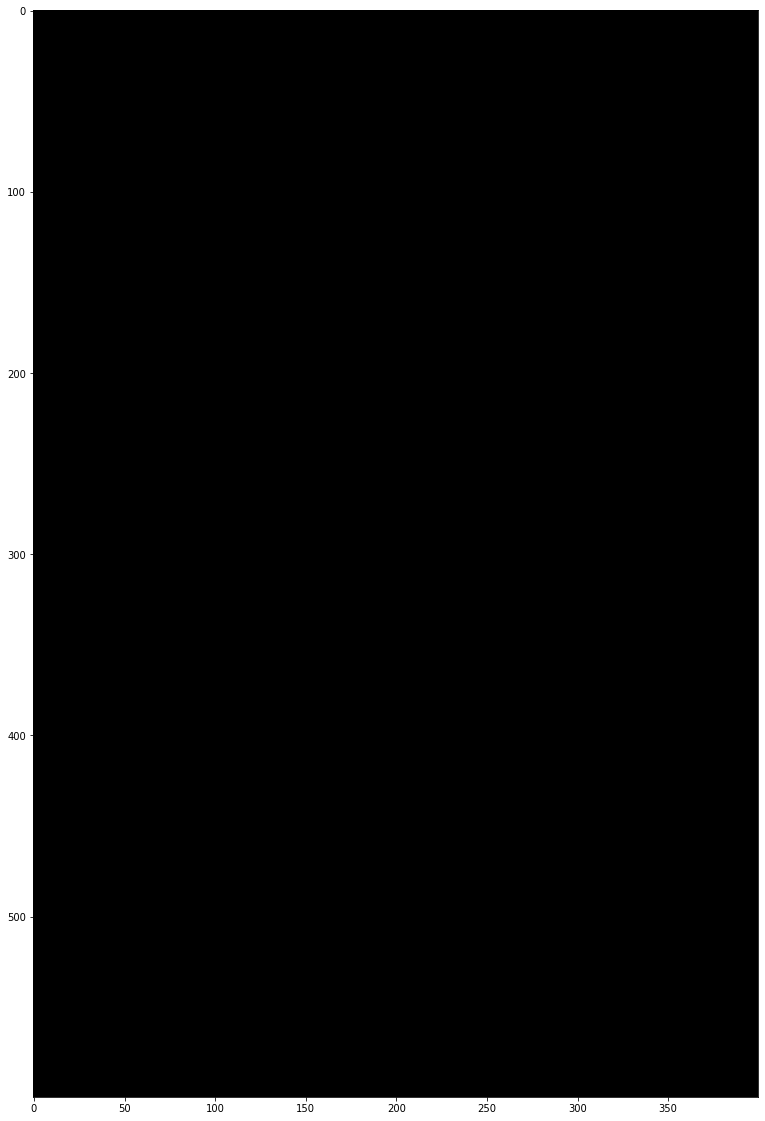

In [30]:
# 배치완료 이미지를 확인하기
background = np.zeros((600, 400, 3))
image_resize_edge.append(background)

after_padd = arrange.padding_position(image_resize_edge,index);
final_image, final_record = arrange.projection_image(after_padd)
cv2.imwrite(f'/content/drive/MyDrive/Colab Notebooks/collage/result/{datetime_text}/final.png', final_image)
plt.figure(figsize=(20,20))
plt.imshow(final_image)

In [31]:
import pandas as pd

def last_return(dict_):
  """
  마지막으로 웹에 적용할 최종리턴 값을 적용
  """
  last_return_dict = {
      'keyword' : dict_['keyword'],
      'article_link' : dict_['links'][dict_['title_picked']],
      'article_title' : dict_['articles'][dict_['title_picked']][0].strip(),
      'article_summary' : dict_['article_summary'],
      'img' : f'/content/drive/MyDrive/Colab Notebooks/collage/result/{datetime_text}/final_img/{dict_["img_name"]}',
      'img_x' : dict_['img_coor'][1],
      'img_y' : dict_['img_coor'][0],
      'img_article' : f'/content/drive/MyDrive/Colab Notebooks/collage/result/{datetime_text}/article_img/{dict_["img_name"]}',
      'time' : datetime_text
  }
  return last_return_dict
# 웹에 리턴할 csv생성
ret_csv = pd.DataFrame()
for kd in [last_return(dict_) for dict_ in keyword_dicts 
          #  if dict_['img_coor'] is not None
           ]:
  ret_csv = ret_csv.append(kd, ignore_index=True)

display(ret_csv)
ret_csv.to_csv('/content/drive/MyDrive/Colab Notebooks/collage/django/collage/collageapp/csv/collage.csv', index=False, encoding="utf-8-sig")

,keyword,article_link,article_title,article_summary,img,img_x,img_y,img_article,time
0,요양병원 면회제한 유지,https://n.news.naver.com/mnews/article/057/000...,"한덕수 ""추석에도 요양병원 '대면접촉 면회 제한' 유지""",정부는 올 추석 연휴에도 '거리두기' 없는 명절 연휴를 위해 요양병원 '대면접촉 면...,/content/drive/MyDrive/Colab Notebooks/collage...,None,None,/content/drive/MyDrive/Colab Notebooks/collage...,2022-08-24 10:59
1,우영우 박은빈,https://n.news.naver.com/mnews/article/009/000...,"강기영 화보 ""'우영우'로 많이 배워, 박은빈 존경""",' ‘이상한 변호사 우영우’를 통해 많은 사랑을 받고 있는 강기영의 화보가 ‘코스모...,/content/drive/MyDrive/Colab Notebooks/collage...,None,None,/content/drive/MyDrive/Colab Notebooks/collage...,2022-08-24 10:59
2,선우은숙,https://n.news.naver.com/mnews/article/312/000...,"[종합] 장나라, ♥6살 연하 남편 최초 공개…박원숙 ""너무 잘생겼다"" 감탄 ('같...",23일 방송된 KBS2 예능 '박원숙의 같이 삽시다'에서는 게스트 선우은숙을 기다리...,/content/drive/MyDrive/Colab Notebooks/collage...,None,None,/content/drive/MyDrive/Colab Notebooks/collage...,2022-08-24 10:59
3,환혼,https://n.news.naver.com/mnews/article/215/000...,"‘환혼’ 이재욱, 장욱의 발단-전개-위기-절정 예측 불가 스토리 관심 집중",tvN대일드라마 환혼 18회 방송이 자체 최고 시청률을 기록하며 시청자들의 관심을 ...,/content/drive/MyDrive/Colab Notebooks/collage...,None,None,/content/drive/MyDrive/Colab Notebooks/collage...,2022-08-24 10:59
4,아담 24라운드 MVP,https://sports.news.naver.com/news.nhn?oid=445...,"'김천전 멀티골' 울산 현대 마틴 아담, K리그1 24라운드 MVP",21일리그2 34라운드 MVP는 대전월드컵경기장에서 열린 대전 하나시티즌과 FC안양...,/content/drive/MyDrive/Colab Notebooks/collage...,None,None,/content/drive/MyDrive/Colab Notebooks/collage...,2022-08-24 10:59
5,이재명 당원투표 박용진,https://n.news.naver.com/mnews/article/032/000...,"이재명·박용진, 전당대회 마지막 토론 ‘권리당원 전원 투표’ 설전",더불어민주당 8·28 전당대회 대표 경선 후보인 이재명 후보와 박용진 후보는 전당대...,/content/drive/MyDrive/Colab Notebooks/collage...,None,None,/content/drive/MyDrive/Colab Notebooks/collage...,2022-08-24 10:59
6,산이 결혼,https://n.news.naver.com/mnews/article/311/000...,"[단독] '9월 결혼' 산이 ""예상치 못한 뉴스에 놀라…행복하겠다""(인터뷰)",한국 산이가 9월 24일 오후 서울 청담동 모처에서 결혼하며 예비신부는 2살 연하의...,/content/drive/MyDrive/Colab Notebooks/collage...,None,None,/content/drive/MyDrive/Colab Notebooks/collage...,2022-08-24 10:59
7,문재인,https://n.news.naver.com/mnews/article/022/000...,우상호 “감사원 文정부 보복성 감사… 월권행위 법률적 대응할 것”,우상호 더불어민주당 비상대책위원장이 24일 국회에서 열린 비상대책위원회의에서 문재인...,/content/drive/MyDrive/Colab Notebooks/collage...,None,None,/content/drive/MyDrive/Colab Notebooks/collage...,2022-08-24 10:59
8,미남당,https://n.news.naver.com/mnews/article/241/000...,"‘미남당’ 강미나, 종영 소감 “많은 것을 배운 소중한 작품”",가수 겸 배우 강미나가 23일 방송된 KBS2 월화드라마 ‘미남당’ 마지막 회에서 ...,/content/drive/MyDrive/Colab Notebooks/collage...,None,None,/content/drive/MyDrive/Colab Notebooks/collage...,2022-08-24 10:59
9,스맨파,https://n.news.naver.com/mnews/article/468/000...,"프라임킹즈, 연이어 승리 거머쥐며 독주…배틀 최강자 군림('스맨파')","지난넷넷 '스트릿 맨 파이터'는 위댐보이즈, 크럼프의 일인자 크루 프라임킹즈, 엠비...",/content/drive/MyDrive/Colab Notebooks/collage...,None,None,/content/drive/MyDrive/Colab Notebooks/collage...,2022-08-24 10:59


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/collage/django/collage')
from google.colab.output import eval_js

print(eval_js("google.colab.kernel.proxyPort(8000)"))
!python manage.py runserver 8000